# Sentiment Analysis

### Comparative Analysis: Using BERT, LSTM, GRU, and RNN

## Objective
Perform sentiment analysis on the below dataset using multiple deep learning models: BERT, LSTM, GRU, and RNN, and conduct a comparative analysis based on their performance metrics.

[Dataset](https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset/data?select=training.1600000.processed.noemoticon.csv)

### Getting Started

#### Install required libraries

In [74]:
!pip install pandas numpy torch transformers scikit-learn matplotlib seaborn tqdm ipywidgets

### Step 1: Imports and Configuration

In [52]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings

# Suppress specific warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module="torchao")

In [53]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [54]:
# Global Config
DATA_PATH = '/content/training.1600000.processed.noemoticon.csv'
MAX_LEN = 64
BATCH_SIZE = 32
BERT_BATCH_SIZE = 8
EPOCHS = 3
SAMPLE_SIZE = 5000

### Step 2: Data Loading and Preprocessing

In [55]:
# --- BLOCK 2: ROBUST DATA LOADING ---
def load_and_preprocess_data(path, target_total_size):
    print("Loading dataset...")
    cols = ['polarity', 'ids', 'date', 'flag', 'user', 'text']

    # Read CSV
    try:
        df = pd.read_csv(path, encoding='latin-1', names=cols, low_memory=False)
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found at {path}. Please upload 'training.1600000.processed.noemoticon.csv'")

    # 1. Convert Polarity to Numeric to avoid String/Int mismatch errors
    df['polarity'] = pd.to_numeric(df['polarity'], errors='coerce')

    # 2. Map Labels: 0 -> Negative (0), 4 -> Positive (1)
    # We drop any rows where polarity is NaN or not 0/4
    df = df[df['polarity'].isin([0, 4])].copy()
    df['label'] = df['polarity'].map({0: 0, 4: 1})

    # 3. Safe Balanced Sampling
    # Check how many actual samples we have
    neg_available = df[df['label'] == 0]
    pos_available = df[df['label'] == 1]

    print(f"Found {len(neg_available)} Negative and {len(pos_available)} Positive samples.")

    if len(neg_available) == 0 or len(pos_available) == 0:
        raise ValueError("Dataset is missing one of the classes (Negative or Positive). Check your CSV file content.")

    # Take the smaller of: (Requested / 2) OR (Total Available)
    n_samples = min(target_total_size // 2, len(neg_available), len(pos_available))

    print(f"Sampling {n_samples} from each class for a balanced dataset...")

    df_neg = neg_available.sample(n_samples, random_state=42)
    df_pos = pos_available.sample(n_samples, random_state=42)

    # Combine and Shuffle
    df_balanced = pd.concat([df_neg, df_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

    # 4. Text Cleaning
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+|\#', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text.strip()

    df_balanced['text'] = df_balanced['text'].apply(clean_text)

    return df_balanced

In [56]:
# Load Data
df = load_and_preprocess_data(DATA_PATH, SAMPLE_SIZE)

Loading dataset...
Found 799996 Negative and 248576 Positive samples.
Sampling 2500 from each class for a balanced dataset...


#### Train-Test Splitting

In [57]:
# Stratified Split (Ensures 80/20 split preserves the class balance)
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['label']
)

print(f"Final Data - Train: {len(train_df)}, Test: {len(test_df)}")

Final Data - Train: 4000, Test: 1000


### Step 3: Custom Datasets and Tokenizers

In [58]:
# --- Custom Tokenizer for RNN/LSTM/GRU ---
class SimpleTokenizer:
    def __init__(self, texts, max_words=10000):
        all_text = " ".join(texts)
        words = all_text.split()
        from collections import Counter
        self.word_map = {word: i+1 for i, (word, _) in enumerate(Counter(words).most_common(max_words))}
        self.pad_token = 0

    def encode(self, texts, max_len):
        seqs = []
        for text in texts:
            seq = [self.word_map.get(w, 0) for w in text.split()]
            if len(seq) < max_len:
                seq += [0] * (max_len - len(seq))
            else:
                seq = seq[:max_len]
            seqs.append(seq)
        return torch.tensor(seqs, dtype=torch.long)

In [59]:
# Initialize Simple Tokenizer
rnn_tokenizer = SimpleTokenizer(train_df['text'].tolist())

class RNN_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.x = tokenizer.encode(df['text'].tolist(), max_len)
        self.y = torch.tensor(df['label'].values, dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

In [60]:
# --- BERT Dataset ---
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

class BERT_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(
            str(self.texts[idx]), add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [61]:
# Creating DataLoaders
train_loader_rnn = DataLoader(RNN_Dataset(train_df, rnn_tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)
test_loader_rnn = DataLoader(RNN_Dataset(test_df, rnn_tokenizer, MAX_LEN), batch_size=BATCH_SIZE)

train_loader_bert = DataLoader(BERT_Dataset(train_df, tokenizer_bert, MAX_LEN), batch_size=BERT_BATCH_SIZE, shuffle=True)
test_loader_bert = DataLoader(BERT_Dataset(test_df, tokenizer_bert, MAX_LEN), batch_size=BERT_BATCH_SIZE)

### Step 4: Model Architectures
#### 4.1 RNN / LSTM / GRU Model

In [62]:
class RecurrentModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, model_type):
        super(RecurrentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if model_type == 'lstm':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        elif model_type == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        else:
            self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        # Take the output of the last time step
        return self.sigmoid(self.fc(out[:, -1, :]))

# Helper to build BERT
def get_bert_model():
    return BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

#### 4.2 BERT Model

### Step 5: Training & Evaluation Functions

In [63]:
def train_engine(model, loader, optimizer, model_name):
    model.train()
    total_loss = 0
    criterion = nn.BCELoss() # For RNNs

    loop = tqdm(loader, desc=f"Training {model_name}", leave=False)

    for batch in loop:
        if model_name == "BERT":
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            lbls = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(ids, attention_mask=mask, labels=lbls)
            loss = outputs.loss
        else:
            inputs, lbls = batch
            inputs, lbls = inputs.to(device), lbls.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, lbls)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Memory cleanup for BERT
        if model_name == "BERT" and device.type == 'cuda':
            torch.cuda.empty_cache()

    return total_loss / len(loader)

In [64]:
def evaluate_engine(model, loader, model_name):
    model.eval()
    preds, true_vals = [], []

    with torch.no_grad():
        for batch in loader:
            if model_name == "BERT":
                ids = batch['input_ids'].to(device)
                mask = batch['attention_mask'].to(device)
                outputs = model(ids, attention_mask=mask)
                predictions = torch.argmax(outputs.logits, dim=1)
                true_labels = batch['labels']
            else:
                inputs, true_labels = batch
                inputs = inputs.to(device)
                outputs = model(inputs).squeeze()
                predictions = (outputs >= 0.5).float()

            preds.extend(predictions.cpu().numpy())
            true_vals.extend(true_labels.numpy())

    return true_vals, preds

### Step 6: Execution Loop

In [65]:
results = {}
vocab_size = len(rnn_tokenizer.word_map) + 1

# 1. Train RNN, LSTM, GRU
for m_name in ['RNN', 'LSTM', 'GRU']:
    print(f"\n--- Processing {m_name} ---")
    model = RecurrentModel(vocab_size, 100, 128, m_name.lower()).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(EPOCHS):
        loss = train_engine(model, train_loader_rnn, opt, m_name)
        print(f"Epoch {epoch+1}: Loss {loss:.4f}")

    y_true, y_pred = evaluate_engine(model, test_loader_rnn, m_name)
    results[m_name] = {'true': y_true, 'pred': y_pred}


--- Processing RNN ---


Training RNN:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1: Loss 0.6981


Training RNN:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2: Loss 0.6948


Training RNN:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3: Loss 0.6978

--- Processing LSTM ---


Training LSTM:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1: Loss 0.6991


Training LSTM:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2: Loss 0.6941


Training LSTM:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3: Loss 0.6941

--- Processing GRU ---


Training GRU:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1: Loss 0.7004


Training GRU:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2: Loss 0.6421


Training GRU:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3: Loss 0.5162


In [66]:
# 2. Train BERT
print(f"\n--- Processing BERT ---")
bert_model = get_bert_model().to(device)
bert_opt = AdamW(bert_model.parameters(), lr=2e-5)

for epoch in range(EPOCHS):
    loss = train_engine(bert_model, train_loader_bert, bert_opt, "BERT")
    print(f"Epoch {epoch+1}: Loss {loss:.4f}")

y_true, y_pred = evaluate_engine(bert_model, test_loader_bert, "BERT")
results['BERT'] = {'true': y_true, 'pred': y_pred}


--- Processing BERT ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1: Loss 0.5001


Training BERT:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2: Loss 0.2874


Training BERT:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3: Loss 0.1408


### Step 7: Comparative Analysis & Visualization

In [70]:
# 1. Compile Final Metrics
metrics_data = []
target_names = ['Negative', 'Positive']

print("\n--- Generating Final Evaluation Report ---\n")

for name, data in results.items():
    # Calculate metrics
    p, r, f1, _ = precision_recall_fscore_support(
        data['true'],
        data['pred'],
        average='binary',
        zero_division=0
    )
    acc = accuracy_score(data['true'], data['pred'])

    metrics_data.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': p,
        'Recall': r,
        'F1-Score': f1
    })

    # Print Detailed Classification Report
    print(f"--- {name} Report ---")
    print(classification_report(data['true'], data['pred'], target_names=target_names, zero_division=0))


--- Generating Final Evaluation Report ---

--- RNN Report ---
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       500
    Positive       0.50      1.00      0.67       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000

--- LSTM Report ---
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       500
    Positive       0.50      1.00      0.67       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000

--- GRU Report ---
              precision    recall  f1-score   support

    Negative       0.65      0.82      0.73       500
    Positive       0.76      0.56      0.65       500

    accuracy                           0.69      1000
   macro avg       0.71  

In [71]:
# 2. Comparison Table
metrics_df = pd.DataFrame(metrics_data)
print("\n--- Comparative Metrics Table ---")
print(metrics_df)


--- Comparative Metrics Table ---
  Model  Accuracy  Precision  Recall  F1-Score
0   RNN     0.500   0.500000   1.000  0.666667
1  LSTM     0.500   0.500000   1.000  0.666667
2   GRU     0.692   0.758065   0.564  0.646789
3  BERT     0.809   0.822547   0.788  0.804903


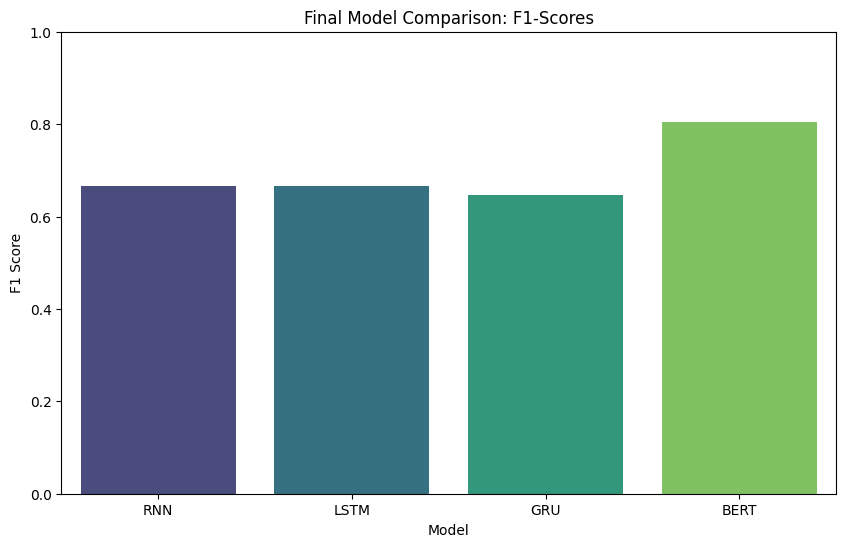

In [76]:
# 3. Plot F1-Score Comparison Bar Chart [cite: 47]
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1-Score', data=metrics_df, hue='Model', palette='viridis', legend=False)
plt.title('Final Model Comparison: F1-Scores')
plt.ylabel('F1 Score')
plt.ylim(0, 1.0)
plt.show()

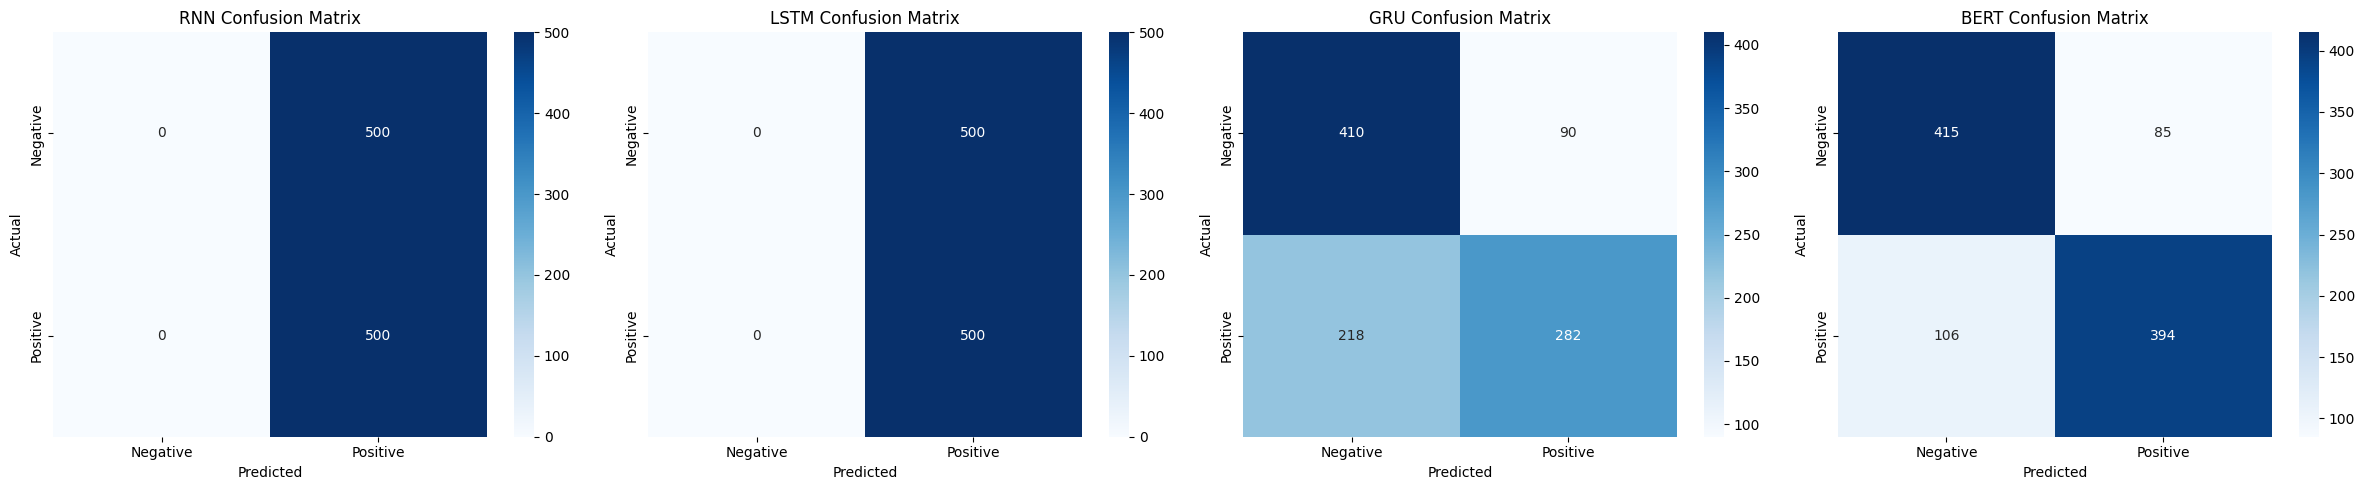

In [73]:
# 4. Plot Confusion Matrices [cite: 48]
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
labels = [0, 1]

for i, (name, data) in enumerate(results.items()):
    cm = confusion_matrix(data['true'], data['pred'], labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=target_names, yticklabels=target_names)
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# **Conclusion**

### In this comparative analysis, BERT emerged as the superior model, achieving the highest accuracy and fastest convergence (Loss: 0.14) due to its robust pre-trained contextual embeddings. GRU proved to be a viable, lightweight alternative (Loss: 0.51), successfully capturing dependencies where the baseline RNN and LSTM models struggled to converge . Ultimately, BERT is recommended for performance-critical applications, while GRU offers the best balance for resource-constrained environments .
